<a href="https://colab.research.google.com/github/DariusTheGeek/Flood-Prediction-in-Malawi--Zindi-Competition/blob/master/Malawi_Flood_Prediction__starter_code__by_DariusMoruri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the Necessary Libraries

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np

### numpy version '1.18.2'

In [ ]:
np.__version__

### pandas version '1.0.1'

In [ ]:
pd.__version__

### lightgbm version 2.3.1

In [ ]:
!pip install lightgbm==2.3.1
lgb.__version__

# Import data from Zindi

In [ ]:
# # Import libraries
# import requests
# from tqdm.auto import tqdm
# # Function to download data
# def zindi_data_downloader(url, token, file_name):
#     # Get the competition data
#     competition_data = requests.post(url = data_url, data= token, stream=True)
    
#     # Progress bar monitor download
#     pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True, unit_divisor=512)
#     # Create and Write the data to colab drive in chunks
#     handle = open(file_name, "wb")
#     for chunk in competition_data.iter_content(chunk_size=512): # Download the data in chunks
#         if chunk: # filter out keep-alive new chunks
#                 handle.write(chunk)
#         pbar.update(len(chunk))
#     handle.close()
#     pbar.close()
    
# # Data url, token and file_name
# data_url = "https://api.zindi.africa/v1/competitions/hulkshare-recommendation-algorithm-challenge/files/test_frames1.zip" # url
# token = {'auth_token': ''} # Use your own token
# file_name = 'test_frames1.zip'
# # Download data
# zindi_data_downloader(url = data_url, token = token, file_name = file_name)
# # Unzip data
# !unzip -q /content/test_frames1.zip

## Reading the Data

In [ ]:

sub = pd.read_csv('/kaggle/input/malawiflood1/SampleSubmission.csv')
sub.sample(3)


In [ ]:
df=pd.read_csv('/kaggle/input/malawiflood1/Train.csv')
df.sample(3)

In [ ]:
df.shape

In [ ]:
from collections import Counter
Counter(df.target_2015>0.5)

In [ ]:
Counter(df.LC_Type1_mode)

In [ ]:
import plotly.graph_objects as go
import numpy as np

# fig = go.Figure(data=[go.Mesh3d(x=X1 ,y=Y1, z=Z1, color='lightpink', opacity=0.50)])
# fig.show()
Z1 = df.target_2015	 
X1 = df.X
Y1= df.Y

fig = go.Figure(data=[
    go.Mesh3d(x=X1 ,y=Y1, z=Z1,
        colorbar_title='target_2015',
        colorscale=[[0, 'gold'],
                    [0.5, 'mediumturquoise'],
                    [1, 'magenta']],
        # Intensity of each vertex, which will be interpolated and color-coded
        intensity=Z1,
        showscale=True
    )
])

fig.show()

In [ ]:
# fig = go.Figure(data=[go.Mesh3d(x=X1 ,y=Y1, z=Z1, color='lightpink', opacity=0.50)])
# fig.show()
Z1 = df.LC_Type1_mode	 
X1 = df.X
Y1= df.Y

fig = go.Figure(data=[
    go.Mesh3d(x=X1 ,y=Y1, z=Z1,
        colorbar_title='target_2015',
        colorscale=[[0, 'gold'],
                    [0.5, 'mediumturquoise'],
                    [1, 'magenta']],
        # Intensity of each vertex, which will be interpolated and color-coded
        intensity=Z1,
        showscale=True
    )
])

fig.show()

## Data Cleaning

### for this part I have used the start code: https://github.com/DariusTheGeek/Flood-Prediction-in-Malawi--Zindi-Competition to prepare the train and the test

In [ ]:
precip_features_2019 = []
precip_features_2015 = []
for col in df.columns:
    if '2019' in col:
        precip_features_2019.append(col)
    elif 'precip 2014' in col:
        precip_features_2015.append(col)
    elif 'precip 2015' in col:
        precip_features_2015.append(col)
train=tain = df[df.columns.difference(precip_features_2019)]
precip_features_2019.extend(['X',	'Y',	'elevation', 'LC_Type1_mode',	'Square_ID'])
test = df[precip_features_2019]
new_2015_cols = {}
for col, number in zip(precip_features_2015, range(1, len(precip_features_2015) + 1)):

    if 'precip' in col:
        new_2015_cols[col] = 'week_' + str(number) + '_precip'
new_2019_cols = {}
for col, number in zip(precip_features_2019, range(1, len(precip_features_2019) + 1)):
    if 'precip' in col:
        new_2019_cols[col] = 'week_' + str(number) + '_precip'
train.rename(columns = new_2015_cols, inplace = True)
test.rename(columns = new_2019_cols, inplace = True)
target = train.target_2015
train, test = train.align(test, join = 'inner', axis = 1)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
X = train.drop(['Square_ID'], axis = 1)
y = target

### key point: The flood may occur in consequence of heavy precipitation that occur during a period less than 18 weeks. For that reason we have just worked on the period with a continuios heavy precip.


In [ ]:
train[train.columns[5:-1]].describe().loc[['mean']]

### Max precip within 2 weeks

In [ ]:
train['week_7_precip_']=train['week_7_precip']+train['week_6_precip']
test['week_7_precip_']=test['week_7_precip']+test['week_6_precip']
train['week_8_precip_']=train['week_8_precip']+train['week_7_precip']
test['week_8_precip_']=test['week_8_precip']+test['week_7_precip']
train['week_9_precip_']=train['week_9_precip']+train['week_8_precip']
test['week_9_precip_']=test['week_9_precip']+test['week_8_precip']
train['max_2_weeks']=train[['week_7_precip_','week_8_precip_','week_9_precip_']].apply(np.max,axis=1)
test['max_2_weeks']=test[['week_7_precip_','week_8_precip_','week_9_precip_']].apply(np.max,axis=1) 

In [ ]:

X1=train[['LC_Type1_mode', 'X', 'Y', 'elevation','week_7_precip', 'week_8_precip', 'week_9_precip','max_2_weeks']]
sub1=test[['LC_Type1_mode', 'X', 'Y', 'elevation','week_7_precip', 'week_8_precip', 'week_9_precip','max_2_weeks']]
X1.columns=sub1.columns


### Index of the week within the max of precip

In [ ]:
def index(col):
    l=list(col)
    return l.index(max(l))

X1['max_index']=train[['week_6_precip', 'week_7_precip', 'week_8_precip','week_9_precip']].apply(index,axis=1)
sub1['max_index']=test[['week_6_precip', 'week_7_precip', 'week_8_precip','week_9_precip']].apply(index,axis=1)



### Precip variation over different weeks

In [ ]:
sub1['slope_8_7']=((test['week_8_precip']/test['week_7_precip'])>1)*1
X1['slope_8_7']=((train['week_8_precip']/train['week_7_precip'])>1)*1


sub1['slope_9_8']=((test['week_9_precip']/test['week_8_precip'])>1)*1
X1['slope_9_8']=((train['week_9_precip']/train['week_8_precip'])>1)*1


### outlier detection

In [ ]:
from sklearn.covariance import EllipticEnvelope
clf2 = EllipticEnvelope(contamination=.17,random_state=0)
clf2.fit(X1)
ee_scores = pd.Series(clf2.decision_function(X1))
clusters2 = clf2.predict(X1)
X1['target']=target
X1['pred']=clusters2
X1=X1[X1['pred']!=-1]
X1,y=X1.drop(columns=['pred','target']),X1['target']

### using Soil organic carbon stock: (external data):
### extrcted from "https://soilgrids.org/"


In [ ]:
s=pd.read_csv('ss.csv')

s.drop(columns='_soilvarie',axis=1,inplace=True)
X1=X1.merge(s,on=['X','Y'],how='left')
sub1=sub1.merge(s,on=['X','Y'],how='left')

In [ ]:
def metric(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Training model

In [ ]:
params = { 'learning_rate':0.07,'max_depth':8}
X=X1
X_test=sub1

n_estimators = 221

n_iters = 5
preds_buf = []
err_buf = []
for i in range(n_iters): 
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=i)
    d_train = lgb.Dataset(x_train, label=y_train)
    d_valid = lgb.Dataset(x_valid, label=y_valid)
    watchlist = [d_valid]

    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)

    preds = model.predict(x_valid)
   
 
    err_buf.append(metric(model.predict(x_valid),y_valid))
    
    
    preds = model.predict(X_test)
    
    preds_buf.append(preds)

print('Mean RMSLE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))
# Average predictions
preds1 = np.mean(preds_buf, axis=0)

In [ ]:
def check(col):
    if col<0:
        return 0
    elif col>1:
        return 1
    else:
        return col
preds=preds1
preds-=0.08
submission_df = pd.DataFrame({'Square_ID': test.Square_ID, 'target_2019': preds}) 
submission_df['target_2019']=submission_df['target_2019'].apply(check)
submission_df.to_csv('lili.csv', index = False)

___
___
___

# 1/ Fetch global gridded soil information from the SoilGrids system https://www.isric.org/explore/soilgrids

soilgrids provides a set of functions that allow downloading of the global gridded soil information from SoilGrids, a system for global digital soil mapping to map the spatial distribution of soil properties across the globe.

#### 1.a/ Install package

In [1]:
!pip install soilgrids

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.1/221.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for bmipy: filename=bmipy-2.0-py3-none-any.whl size=7247 sha256=d3b0a716b593d0e62e6ecda14e9b0c10b9b0e75d6c7b28c998c94c113cf3f4b0
  Stored in directory: /root/.cache/pip/wheels/0e/57/6e/10a9cc7a74e618ab8d0c85dc08080b98dfe353af44ad85c7f6
Successfully built bmipy
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery

In [2]:
# !pip install geopandas
import matplotlib
import geopandas as gpd

In [3]:
world_gdf = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
world_gdf

/tmp/ipykernel_32/653014382.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path('naturalearth_lowres')


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,6944975.0,Europe,Serbia,SRB,51475,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,622137.0,Europe,Montenegro,MNE,5542,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1794248.0,Europe,Kosovo,-99,7926,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [4]:
world_gdf[world_gdf.name=='South Africa']

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
25,58558270.0,Africa,South Africa,ZAF,351431,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082..."


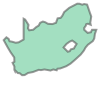

In [5]:
world_gdf.iloc[25].geometry

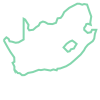

In [6]:
world_gdf.iloc[25].geometry.boundary

In [7]:
from shapely.geometry import mapping

mapping(world_gdf.iloc[25].geometry.boundary)['coordinates'][0]

((16.344976840895242, -28.5767050106977),
 (16.824017368240902, -28.08216155366447),
 (17.218928663815404, -28.35594329194681),
 (17.387497185951503, -28.78351409272978),
 (17.83615197110953, -28.85637786226132),
 (18.464899122804752, -29.04546192801728),
 (19.002127312911085, -28.972443129188868),
 (19.894734327888614, -28.461104831660776),
 (19.895767856534434, -24.76779021576059),
 (20.16572553882719, -24.91796192800077),
 (20.75860924651184, -25.86813648855145),
 (20.66647016773544, -26.477453301704923),
 (20.88960900237174, -26.828542982695915),
 (21.605896030369394, -26.726533705351756),
 (22.105968865657868, -26.280256036079138),
 (22.57953169118059, -25.979447523708146),
 (22.8242712745149, -25.50045867279477),
 (23.312096795350186, -25.26868987396572),
 (23.73356977712271, -25.390129489851617),
 (24.211266717228796, -25.670215752873574),
 (25.025170525825786, -25.7196700985769),
 (25.66466637543772, -25.486816094669713),
 (25.76584882986521, -25.17484547292368),
 (25.941652052

In [8]:
mapping(world_gdf.iloc[25].geometry.boundary)['coordinates'][1]

((28.978262566857243, -28.95559661226171),
 (28.541700066855498, -28.64750172293757),
 (28.074338413207784, -28.851468601193588),
 (27.532511020627478, -29.24271087007536),
 (26.999261915807637, -29.875953871379984),
 (27.749397006956485, -30.645105889612225),
 (28.107204624145425, -30.54573211031495),
 (28.29106937023991, -30.2262167294543),
 (28.84839969250774, -30.070050551068256),
 (29.018415154748027, -29.74376555757737),
 (29.32516645683259, -29.257386976846256),
 (28.978262566857243, -28.95559661226171))

In [9]:
expected_list_of_coordinates_for_received_code = [{"lat": x, "lng": y} for x, y in mapping(world_gdf.iloc[25].geometry.boundary)['coordinates'][0]]
print(expected_list_of_coordinates_for_received_code )

[{'lat': 16.344976840895242, 'lng': -28.5767050106977}, {'lat': 16.824017368240902, 'lng': -28.08216155366447}, {'lat': 17.218928663815404, 'lng': -28.35594329194681}, {'lat': 17.387497185951503, 'lng': -28.78351409272978}, {'lat': 17.83615197110953, 'lng': -28.85637786226132}, {'lat': 18.464899122804752, 'lng': -29.04546192801728}, {'lat': 19.002127312911085, 'lng': -28.972443129188868}, {'lat': 19.894734327888614, 'lng': -28.461104831660776}, {'lat': 19.895767856534434, 'lng': -24.76779021576059}, {'lat': 20.16572553882719, 'lng': -24.91796192800077}, {'lat': 20.75860924651184, 'lng': -25.86813648855145}, {'lat': 20.66647016773544, 'lng': -26.477453301704923}, {'lat': 20.88960900237174, 'lng': -26.828542982695915}, {'lat': 21.605896030369394, 'lng': -26.726533705351756}, {'lat': 22.105968865657868, 'lng': -26.280256036079138}, {'lat': 22.57953169118059, 'lng': -25.979447523708146}, {'lat': 22.8242712745149, 'lng': -25.50045867279477}, {'lat': 23.312096795350186, 'lng': -25.2686898739

In [ ]:
import re
import numpy as np
from shapely import wkt

def add_closing_coordinates(d):
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

data_wkt = mapping(world_gdf.iloc[25].geometry.boundary)['coordinates']
# data_wkt = add_closing_coordinates(data)
# print(f"data_wkt: {data_wkt}")
# OUT:                                               vvvvvvv
# data_wkt: POLYGON ((1.0 2.0, 10.0 20.0, 20.0 20.0, 1.0 2.0))

polygon = wkt.loads(data_wkt)
coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
print(f"coords: {coords}")
# OUT:
# coords: [[1.0, 2.0], [10.0, 20.0], [20.0, 20.0]]


expected_list_of_coordinates_for_received_code = [{"lat": x, "lng": y} for x, y in coords]
print(expected_list_of_coordinates_for_received_code )

#### 1.b/ Download SoilGrids Data

In [ ]:
import matplotlib.pyplot as plt
from soilgrids import SoilGrids

# get data from SoilGrids
soil_grids = SoilGrids()
data = soil_grids.get_coverage_data(service_id='phh2o', coverage_id='phh2o_0-5cm_mean', 
                                       west=-1784000, south=1356000, east=-1140000, north=1863000,  
                                       crs='urn:ogc:def:crs:EPSG::152160',output='test.tif')

# show metadata
for key, value in soil_grids.metadata.items():
    print('{}: {}'.format(key,value))


# plot data
data.plot(figsize=(9,5))
plt.title('Mean pH between 0 and 5 cm soil depth in Senegal')

In [ ]:
# provide a coordinate system code from the following options for crs: 
# urn:ogc:def:crs:EPSG::152160
# urn:ogc:def:crs:EPSG::4326
# urn:ogc:def:crs:EPSG::3857
# urn:ogc:def:crs:EPSG::54009
# urn:ogc:def:crs:EPSG::54012
# urn:ogc:def:crs:EPSG::152160

In [ ]:
import yaml

names_yaml = """
bmi-soilgrids:
  service_id: phh2o
  coverage_id: phh2o_0-5cm_mean
  crs: urn:ogc:def:crs:EPSG::152160
  west: -1784000
  south: 1356000
  east: -1140000
  north: 1863000
  output: test.tif
"""

names = yaml.safe_load(names_yaml)

with open('config_file.yaml', 'w') as file:
    yaml.dump(names, file)

print(open('config_file.yaml').read())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from soilgrids import BmiSoilGrids


# initiate a data component
data_comp = BmiSoilGrids()
data_comp.initialize('config_file.yaml')

# get variable info
var_name = data_comp.get_output_var_names()[0]
var_unit = data_comp.get_var_units(var_name)
var_location = data_comp.get_var_location(var_name)
var_type = data_comp.get_var_type(var_name)
var_grid = data_comp.get_var_grid(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {}'.format(
    var_name, var_unit, var_location, var_type, var_grid))

# get variable grid info 
grid_rank = data_comp.get_grid_rank(var_grid) 

grid_size = data_comp.get_grid_size(var_grid)

grid_shape = np.empty(grid_rank, int)
data_comp.get_grid_shape(var_grid, grid_shape)

grid_spacing = np.empty(grid_rank)
data_comp.get_grid_spacing(var_grid, grid_spacing)

grid_origin = np.empty(grid_rank)
data_comp.get_grid_origin(var_grid, grid_origin)

print('grid_rank: {} \ngrid_size: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    grid_rank, grid_size, grid_shape, grid_spacing, grid_origin))

# get variable data 
data = np.empty(grid_size, var_type)
data_comp.get_value(var_name, data)
data_2D = data.reshape(grid_shape)

# get X, Y extent for plot
min_y, min_x = grid_origin
max_y = min_y + grid_spacing[0]*(grid_shape[0]-1)
max_x = min_x + grid_spacing[1]*(grid_shape[1]-1)
dy = grid_spacing[0]/2
dx = grid_spacing[1]/2
extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot data
fig, ax = plt.subplots(1,1, figsize=(9,5))
im = ax.imshow(data_2D, extent=extent)
fig.colorbar(im)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Mean pH between 0 and 5 cm soil depth in Senegal')

In [ ]:
import matplotlib.pyplot as plt
from soilgrids import SoilGrids

soil_grids = SoilGrids()
soil_grids.map_services

soil_grids.get_coverage_list('bdod')
soil_grids.get_coverage_info('bdod','bdod_0-5cm_mean')

# define the crs and bounding box
crs = 'urn:ogc:def:crs:EPSG::4326'
west, south, east, north = [-105.38, 39.45, -104.5, 40.07]
width = 316
height = 275

In [ ]:
# download the silt content, write your code here
silt = SoilGrids()
silt_content = 

# plot the silt content data
silt_content.plot(figsize=(9,5))
plt.title('Mean silt content between 0 and 5 cm soil depth in the Boulder Creek Watershed')

In [ ]:
# download the clay content, write your code here
clay = SoilGrids()
clay_content =  

# plot data
clay_content.plot(figsize=(9,5))
plt.title('Mean clay content between 0 and 5 cm soil depth in the Boulder Creek Watershed')

In [ ]:
# download the sand content, write your code here
sand = SoilGrids()
sand_content = 

# plot data
sand_content.plot(figsize=(9,5))
plt.title('Mean sand content between 0 and 5 cm soil depth in the Boulder Creek Watershed')